<a href="https://colab.research.google.com/github/amudhan023/DeepLearning/blob/main/Pytorch_multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [219]:
!pip install torchmetrics

X_blob - tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815],
        [-6.7941, -6.4772],
        [ 5.2102,  2.8890],
        [-5.5051, -6.3604],
        [-6.5438, -4.8339],
        [ 6.4496,  0.7478]]),len X_blob - 1000
y_blob - tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1]),len y_blob - 1000
Device of x_blob_train cpu 


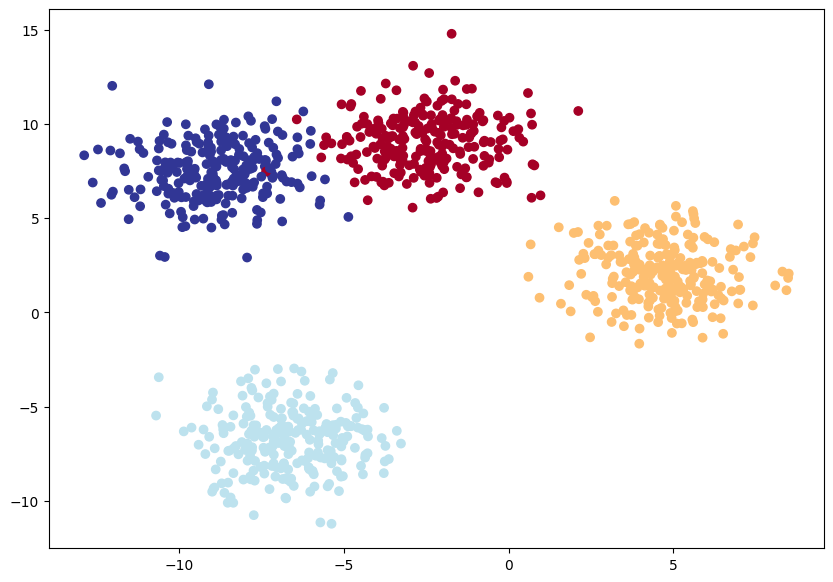

In [220]:
# Create toy dataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MulticlassAccuracy



device = "cuda" if torch.cuda.is_available() else "cpu"
device

# set the hyperparameters for data creation

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std =1.5,
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

print(f"X_blob - {X_blob[:10]},len X_blob - {len(X_blob)}")
print(f"y_blob - {y_blob[:10]},len y_blob - {len(y_blob)}")

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)


print(f"Device of x_blob_train {X_blob_train.device} ")

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

In [221]:
# Build a multi- class classification model

class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

In [222]:
model = BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=4).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [223]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [224]:
# Create a loss function & optimizer for multi class classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)


In [225]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test)

y_logits[:5], y_blob_test[:5]

(tensor([[-0.4154,  0.0652, -0.1503, -0.5198],
         [ 1.2529,  0.3202, -1.3176, -0.6550],
         [-0.2360,  0.1435, -0.1298, -0.3941],
         [-0.5382,  0.0689, -0.1804, -0.6795],
         [ 0.4493,  0.2391, -0.7032, -0.5394]]),
 tensor([1, 3, 2, 1, 0]))

In [226]:
# Convert logits to prediction probabilities, then probabilities to prediction labels

y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_pred_probs[:5])

tensor([[0.2074, 0.3354, 0.2704, 0.1869],
        [0.6179, 0.2432, 0.0473, 0.0917],
        [0.2259, 0.3301, 0.2512, 0.1928],
        [0.1948, 0.3575, 0.2786, 0.1691],
        [0.4003, 0.3244, 0.1264, 0.1489]])


In [227]:
metric = MulticlassAccuracy(num_classes=NUM_CLASSES)

In [228]:
def train(model,X,y):
  model.train()
  y_logits = model(X)
  loss = loss_fn(y_logits,y_blob_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  acc = metric(y_logits,y) * 100
  return acc,loss.item()

def test(model,X,y):
  model.eval()
  with torch.inference_mode():
    y_logits = model(X)
    y_pred_probs = torch.softmax(y_logits,dim=1)
    loss = loss_fn(y_logits,y_blob_test)
    y_preds = torch.argmax(y_pred_probs,dim=1)
    acc = metric(y_logits,y) * 100
    return acc,loss.item()





In [229]:
def train_and_test():
  torch.manual_seed(RANDOM_SEED)
  torch.cuda.manual_seed(RANDOM_SEED)
  epochs = 500
  epoch_count = []
  train_losses = []
  test_losses = []
  train_accs=[]
  test_accs=[]
  for epoch in range(epochs):
    train_acc,train_loss = train(model,X_blob_train,y_blob_train)
    test_acc,test_loss = test(model, X_blob_test,y_blob_test)


    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_accs.append(train_acc)
      test_accs.append(test_acc)

      print(f"Epoch : {epoch} | Train loss : {train_loss:.4f} | Train accuracy : {train_acc:.2f} % | Test loss : {test_loss:.4f} | Test accuracy : {test_acc:.2f} % ")

  return epoch_count,train_losses,test_losses,train_accs,test_accs

In [230]:
epoch_count,train_losses,test_losses,train_accs,test_accs = train_and_test()

Epoch : 0 | Train loss : 1.4116 | Train accuracy : 49.63 % | Test loss : 1.2434 | Test accuracy : 50.00 % 
Epoch : 10 | Train loss : 0.9079 | Train accuracy : 47.97 % | Test loss : 0.8962 | Test accuracy : 48.78 % 
Epoch : 20 | Train loss : 0.7615 | Train accuracy : 49.04 % | Test loss : 0.7699 | Test accuracy : 49.39 % 
Epoch : 30 | Train loss : 0.6615 | Train accuracy : 72.87 % | Test loss : 0.6845 | Test accuracy : 73.45 % 
Epoch : 40 | Train loss : 0.6014 | Train accuracy : 74.99 % | Test loss : 0.6289 | Test accuracy : 73.92 % 
Epoch : 50 | Train loss : 0.5565 | Train accuracy : 78.11 % | Test loss : 0.5828 | Test accuracy : 78.47 % 
Epoch : 60 | Train loss : 0.5051 | Train accuracy : 85.95 % | Test loss : 0.5253 | Test accuracy : 91.84 % 
Epoch : 70 | Train loss : 0.4165 | Train accuracy : 97.27 % | Test loss : 0.4272 | Test accuracy : 98.98 % 
Epoch : 80 | Train loss : 0.3025 | Train accuracy : 98.76 % | Test loss : 0.3085 | Test accuracy : 100.00 % 
Epoch : 90 | Train loss : 0.

In [231]:
def plot_loss_curve():
  plt.figure(figsize=(10,7))
  plt.plot(epoch_count,train_losses,label="Train loss")
  plt.plot(epoch_count,test_losses, label="Test loss")
  plt.plot()

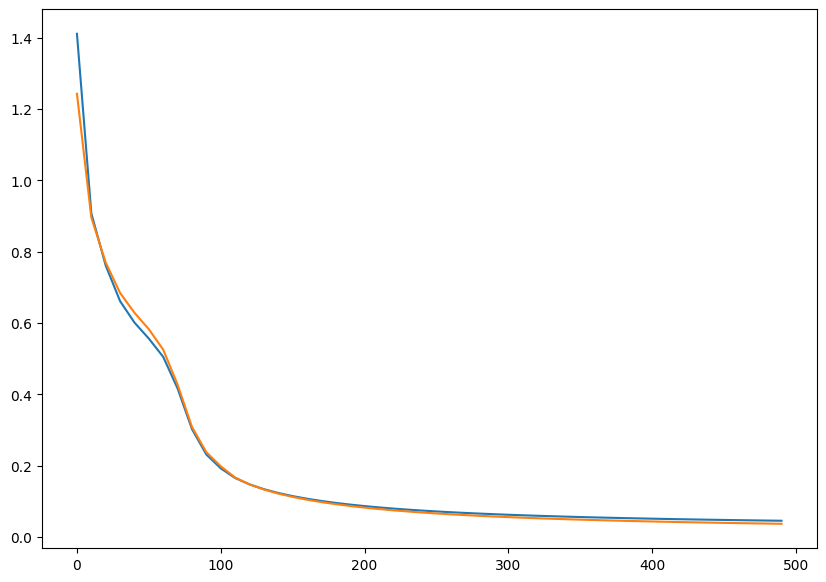

In [232]:
plot_loss_curve()

In [233]:
def plot_accuracy():
  plt.figure(figsize=(10,7))
  plt.plot(epoch_count, train_accs,label= "Train accuracy")
  plt.plot(epoch_count, test_accs, label= "Test accuracy")
  plt.legend()
  plt.plot()


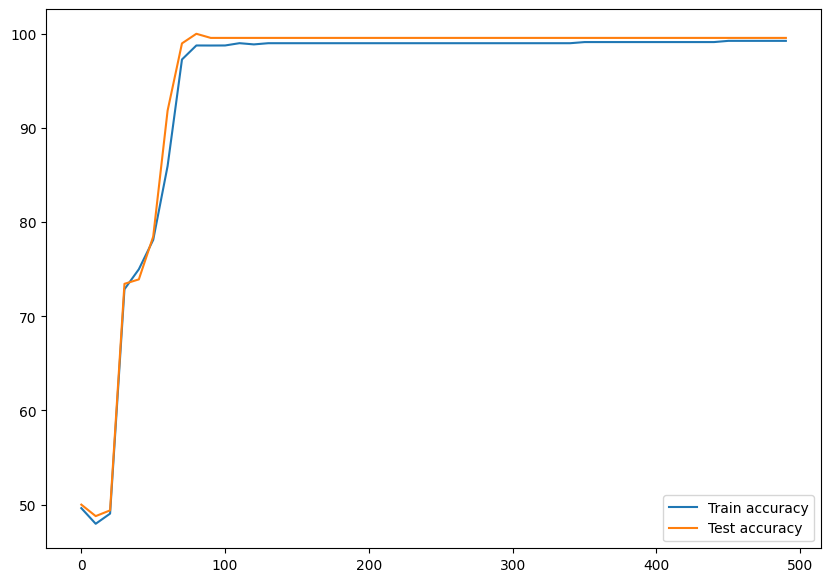

In [234]:
plot_accuracy()